<a href="https://colab.research.google.com/github/PurpleBeetle/IA1900/blob/main/IA_Tarea_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entrenamiento R²: 0.9615698024446129
Test R²: 0.9573584672189804
RMSE: 24148.09867825342


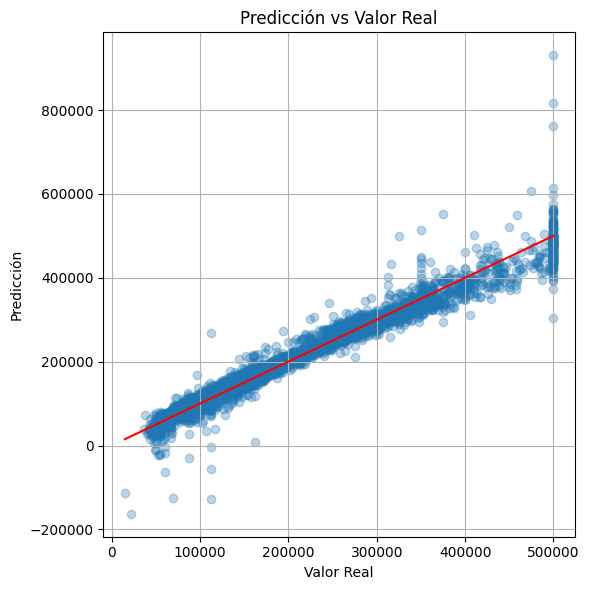

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('./housing.csv')

# Guardamos la columna 'ocean_proximity' con un nuevo nombre 'region' para hacer analisis por zonas
df['region'] = df['ocean_proximity']

# Agrupamos por region y calculamos los promedios de ingreso de la casa por region
region_means = df.groupby('region')[['median_income', 'median_house_value']].mean()

# Creamos una nueva columna que representa la relacion ingreso de la casa por región
region_means['region_income_ratio'] = region_means['median_income'] / region_means['median_house_value']

# Unimos esta nueva columna al DataFrame original para cada fila segun su region
df = df.merge(region_means['region_income_ratio'], on='region', how='left')

# Convertimos la columna categorica 'region' en columnas dummy (0 o 1 por region)
df = pd.concat([df, pd.get_dummies(df['region'], dtype=int)], axis=1)

# Eliminamos columnas que ya no necesitamos
df.drop(['ocean_proximity', 'region'], axis=1, inplace=True)

# Eliminamos cualquier fila que tenga datos faltantes (NaN)
df.dropna(inplace=True)

# Creamos nuevas columnas (features) a partir de combinaciones de las ya existentes

# Estas ayudan a que el modelo tenga mas contexto y aprenda mejor
df['bedroom_ratio'] = df['total_rooms'] / df['total_bedrooms']                 # Cuartos por dormitorio
df['rooms_per_household'] = df['total_rooms'] / df['households']               # Cuartos por hogar
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']             # Proporcion de dormitorios respecto a los cuartos
df['population_per_household'] = df['population'] / df['households']           # Personas por hogar
df['income_per_person'] = df['median_income'] / df['population']               # Ingreso por persona
df['people_per_room'] = df['population'] / df['total_rooms']                   # Personas por cuarto
df['households_per_room'] = df['households'] / df['total_rooms']               # Hogares por cuarto
df['income_times_rooms'] = df['median_income'] * df['total_rooms']             # Ingreso total en relacion con cantidad de cuartos
df['income_times_bedroom_ratio'] = df['median_income'] * df['bedroom_ratio']   # Ingreso ponderado por relacion de cuartos
df['house_value_perbedroom_ratio'] = df['median_house_value'] / df['bedroom_ratio'] # El valor de la casa sobre los cuartos
df['log_total_rooms'] = np.log1p(df['total_rooms'])                            # Logaritmo de total de cuartos (reduce valores extremos)
df['log_population'] = np.log1p(df['population'])                              # Logaritmo de poblacion (reduce valores extremos)

# Creamos variables que representan zonas geográficas por latitud y longitud

df['near_coast'] = ((df['longitude'] > -124) & (df['latitude'] > 32)).astype(int)  # Cerca de la costa sur de California
df['far_north'] = (df['latitude'] > 38).astype(int)                                # En el norte de California
df['central_ca'] = ((df['latitude'] >= 35) & (df['latitude'] <= 37)).astype(int)   # Zona central de California


# Agrupamos los ingresos en categorias discretas (muy bajo, bajo, medio, etc.)
df['income_level'] = pd.cut(df['median_income'],
                            bins=[0, 2, 4, 6, 8, np.inf],
                            labels=['muy_bajo', 'bajo', 'medio', 'alto', 'muy_alto'])

# Convertimos esa columna categorica en variables dummy (0 o 1 por categoria)
df = pd.get_dummies(df, columns=['income_level'], dtype=int)

# Separamos las variables de entrada (X) de la variable objetivo (y)
X = df.drop('median_house_value', axis=1)   # Todas las columnas menos el precio de la casa
y = df['median_house_value']                # Precio de la casa (target)

# Dividimos el dataset en datos de entrenamiento y de prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos el modelo de regresion lineal y lo entrenamos con los datos de entrenamiento
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Usamos el modelo para hacer predicciones
predicciones = modelo.predict(X_test)

print("Entrenamiento R²:", modelo.score(X_train, y_train))
print("Test R²:", modelo.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predicciones)))

plt.figure(figsize=(6,6))
plt.scatter(y_test, predicciones, alpha=0.3)
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()


**Preguntas:**

**¿El resultado fue mejor o peor?**
Fue mejor, pero no por mucho, porque los datos que se dieron no son lineales, aunque en teoria se pudiera acoplar columnas para que muestre datos de forma mas lineal, podrian sesgar o dar muchos falsos positivos al momento de entrenar. Otros metodos de regresion son mucho mejores.

**¿Por qué crees que es así?**

Porque se mejoro lo siguiente:
1. Agregamos mas caracteristicas y categorias
2. Hicimos una separacion por regiones
3. Removimos valores que hacian ruido


**Por metodo de forest regression**


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Cargamos los datos
df = pd.read_csv('housing.csv')


# Aqui eliminamos todas las filas con valores null porque afecta el resultado de nuestro entrenamiento y la referencia entre datos
df.dropna(inplace=True)


# Luego de analizar los datos entre graficos y usando logica de como la tabla  muestra los valores, tenemos que hacer columnas que sean influyentes para el train
# Creamos nuevas columas de combinaciones de las ya existentes para tener valores mas criticos
df["rooms_per_household"] = df["total_rooms"] / df["households"]
# Dividimos el total de rooms entre households para calcular un numero aproximado de cuartos en hogares

df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
# Obtenemos el division de habitaciones sobre cuartos, porque no todo cuarto es una habitacion cual influye el valor

df["population_per_household"] = df["population"] / df["households"]
# Es importante saber un aproximado de gente por hogar, asi se determine la densidad de populacion en la region


# Separar variables para nuestra prediccion
# X son todas la variables que se usaran para predecir el precio de la casa
# y sera el valor que queremos determinar, la precio de la casa
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]


# Luego de reconocer el tipo de columnas, identificamos las columnas numericas y categoricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


# Aqui creamos transformaciones hacia las columnas.
# Las columnas numericas -> StandardScalar. Realiza una media y desviacion estandar
# Las columnas categoricas -> OneHotEncoder. Hace un dummy automatico a cada categoria del dataset .

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Luego de tener nuestros transformers, creamos un pipeline para automatizar el preprocessing\
# Utilizamos RandomForestRegression porque es un metodo mas facil para correlacionar datos ya dados.
# Linear regression no puede adaptarse hacia datos cuales no tienen relaciones lineales
model = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42))
])

# Aqui usamos preprocessing y comenzamos el entrenamiento y prueba.
# Nos aseguramos el esfuerzo de 80% y 20% de test, para que pueda aprender y lograr su 100%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# Ponemos a prueba nuestro modelo y hacemos predicts para reconocer nuestro entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² entrenamiento: {r2_train:.4f}")
print(f"R² prueba: {r2_test:.4f}")


R² entrenamiento: 0.9129
R² prueba: 0.7997


**Preguntas:**

**¿El resultado fue mejor o peor?**
Usando Random Forest Regressor y crear nuevas columnas como *rooms_per_household, bedrooms_per_room, populatio_per_household* obtuvimos mejores resultados de manera que optimizamos el entrenamiento y siendo mejor que el metodo Linear regression.

**¿Por qué crees que es así?**
Simplemente porque el problema no es lineal, aunque se pueda en teoria semejar datos y columnas para que sean lineales para Linear Regression, es mucho mas sencillo usar otro metodo de regresion para tener un mejor entrenamiento sin comprometer datos importante o sesgar nuestro entrenamiento.

Por ejemplo *ocean_proximity* Linear Regression no puede entender que una zona tenga mas valor por nombre.

Text(0.5, 1.0, 'Precio por proximidad al océano')

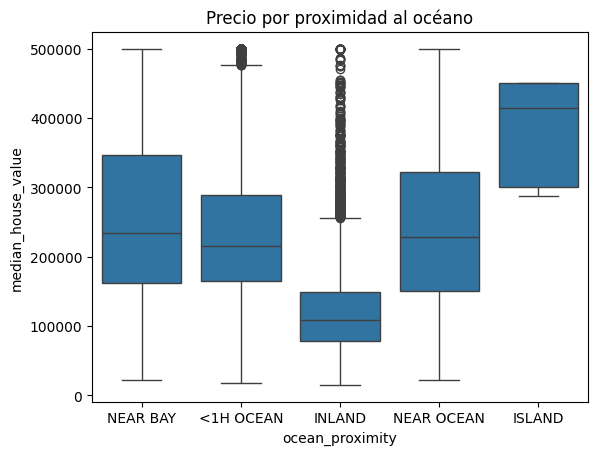

In [ ]:
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value')
plt.title("Precio por proximidad al océano")
